In [1]:
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestRegressor
import gc
import sys
from pprint import pprint

#df_13 = pd.read_csv('13_clean.csv')
#df_13.head()

years = ['85', '87', '89', '91', '93', '95', '97', '99', '01', '03', '05', '07', '09', '11', '13']
years_num = [1985, 1987, 1989, 1991, 1993, 1995, 1997, 1999, 2001, 2003, 2005, 2007, 2009, 2011, 2013 ]


def combineDataFrame(years, years_num):
    
    df_allYears = pd.DataFrame()
    
    for year, i in zip(years, years_num):
        df = pd.read_csv(year + '_clean.csv')
        df['YEAR'] = i
        df_allYears = df_allYears.append(df)
    
    return df_allYears
    
df_allYears = combineDataFrame(years, years_num)

#Keep only LMED from above set since 'ABL50', 'ABL80', 'ABLMED', 'GL50', 'GL80', 'GLMED', 'L50' are correlated
cols = ['ABL50', 'ABL80', 'ABLMED', 'GL50', 'GL80', 'GLMED', 'L50']
df_allYears.drop(cols, axis=1, inplace=True)


#Keep only 'INCRELAMIPCT' from above set since 'ZINC2', 'TOTSAL' are correlated
cols = ['ZINC2', 'TOTSAL']
df_allYears.drop(cols, axis=1, inplace=True)

#choose columns that are independent, e.g. COSTMED, COSTMEDRELAMITPCT, FMTCOSTMEDRELAMIPCT 
#show the same data in different format; ditto for FMTINCRELAMICAT and INCRELAMIPCT
# drop CONTROL as well
cols = ['CONTROL', 'COSTMED', 'FMTCOSTMEDRELAMICAT', 'FMTINCRELAMICAT']
df_allYears.drop(cols, axis=1, inplace=True)
print(df_allYears.shape)

#removing columns related to cost since these are related to target variable ZSMHC (monthly housing cost)
cols = ['COSTMEDRELAMIPCT', 'BURDEN', 'OTHERCOST', 'UTILITY']
df_allYears.drop(cols, axis=1, inplace=True)
print(df_allYears.shape)

#drop na values
df_allYears = df_allYears.dropna()
print(df_allYears.shape)

#remove values of FMTMETRO set to 9;
df_allYears = df_allYears.loc[~df_allYears['FMTMETRO'].str.contains('9', regex=False)]


#drop FMTSTATUS - earlier generated ill-defined matrix warning for ridge regression;
#values for this column is constanct for several years
df_allYears.drop('FMTSTATUS', axis=1, inplace=True)

#converting REGION from int type to string type
df_allYears['REGION'].apply(str)

#convert categorical variables to indicator variables
df_allYears = pd.get_dummies(df_allYears, drop_first=True)

print(df_allYears.columns)

(771870, 24)
(771870, 20)
(486785, 20)
Index(['AGE', 'BEDRMS', 'FMR', 'INCRELAMIPCT', 'IPOV', 'LMED', 'NUNITS', 'PER',
       'ROOMS', 'VALUE', 'ZSMHC', 'REGION', 'YEAR', 'FMTBUILT_'1960-1979'',
       'FMTBUILT_'1980-1989'', 'FMTBUILT_'1990-1999'', 'FMTBUILT_'2000-2009'',
       'FMTBUILT_'After 2010'', 'FMTBUILT_'not_defined'',
       'FMTASSISTED_'0 Not Assisted'', 'FMTSTRUCTURETYPE_'2 2-4 units'',
       'FMTSTRUCTURETYPE_'3 5-19 units'', 'FMTSTRUCTURETYPE_'4 20-49 units'',
       'FMTSTRUCTURETYPE_'5 50+ units'', 'FMTSTRUCTURETYPE_'6 Mobile Home'',
       'FMTMETRO_'Central City'', 'FMTZADEQ_'2 Moderately Inadequ'',
       'FMTZADEQ_'3 Severely Indadequa''],
      dtype='object')


In [2]:
X = df_allYears.drop(['ZSMHC'], axis=1).values

y = df_allYears['ZSMHC'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

del df_allYears
del X
del y

In [3]:
# Number of trees in random forest
n_estimators = [20, 50, 100, 150, 200]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 30, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor(n_jobs=-1, random_state=42)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, \
                               n_iter = 100, cv = 3, verbose=2)

# Fit the random search model
rf_random.fit(X_train, y_train)

print('Hello World!')

{'bootstrap': [True, False],
 'max_depth': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, None],
 'max_features': ['auto', 'sqrt', 'log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [20, 50, 100, 150, 200]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=22, bootstrap=False 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=22, bootstrap=False, total=  11.9s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=22, bootstrap=False 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.9s remaining:    0.0s


[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=22, bootstrap=False, total=  10.0s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=22, bootstrap=False 
[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=1, max_features=log2, max_depth=22, bootstrap=False, total=  10.2s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=True, total= 5.2min
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=True, total= 5.2min
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=200, mi

[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True, total=  43.9s
[CV] n_estimators=20, min_samples_split=10, min_samples_leaf=2, max_features=log2, max_depth=None, bootstrap=False 
[CV]  n_estimators=20, min_samples_split=10, min_samples_leaf=2, max_features=log2, max_depth=None, bootstrap=False, total=   9.6s
[CV] n_estimators=20, min_samples_split=10, min_samples_leaf=2, max_features=log2, max_depth=None, bootstrap=False 
[CV]  n_estimators=20, min_samples_split=10, min_samples_leaf=2, max_features=log2, max_depth=None, bootstrap=False, total=   9.6s
[CV] n_estimators=20, min_samples_split=10, min_samples_leaf=2, max_features=log2, max_depth=None, bootstrap=False 
[CV]  n_estimators=20, min_samples_split=10, min_samples_leaf=2, max_features=log2, max_depth=None, bootstrap=False, total=   9.7s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=18, bootstrap=False 
[CV]  n_estimat

[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=24, bootstrap=False, total= 2.3min
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=24, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=24, bootstrap=False, total= 2.3min
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=24, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=24, bootstrap=False, total= 2.3min
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=4, max_features=log2, max_depth=12, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=2, min_samples_leaf=4, max_features=log2, max_depth=12, bootstrap=True, total=   4.5s
[CV] n_estimators=20, min_samples_split=2, min_samples_leaf=4, max_features=log2, max_depth=12, bootstrap=True 
[CV]  n_estimators=20, min_samples_spli

[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=4, max_features=log2, max_depth=22, bootstrap=True, total=  15.1s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=4, max_features=log2, max_depth=22, bootstrap=True 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=4, max_features=log2, max_depth=22, bootstrap=True, total=  15.1s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=log2, max_depth=18, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=log2, max_depth=18, bootstrap=False, total= 1.4min
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=log2, max_depth=18, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=log2, max_depth=18, bootstrap=False, total= 1.4min
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=log2, max_depth=18, bootstrap=False 
[CV]  n_estimators=200, mi

[CV]  n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=18, bootstrap=False, total= 1.1min
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=30, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=30, bootstrap=True, total= 2.7min
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=30, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=30, bootstrap=True, total= 2.8min
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=30, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=30, bootstrap=True, total= 2.8min
[CV] n_estimators=150, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=28, bootstrap=True 
[CV]  n_estimators=150, min_s

[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=16, bootstrap=False, total= 1.6min
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=16, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=16, bootstrap=False, total= 1.6min
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=16, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=16, bootstrap=False, total= 1.5min
[CV] n_estimators=150, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=10, bootstrap=True 
[CV]  n_estimators=150, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=10, bootstrap=True, total= 2.4min
[CV] n_estimators=150, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=10, bootstrap=True 
[CV]  n_estimators=150, min_sam

[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=24, bootstrap=False, total=  52.4s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=24, bootstrap=False 
[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=24, bootstrap=False, total=  51.4s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=10, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=10, bootstrap=False, total=  26.8s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=10, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=10, bootstrap=False, total=  27.0s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=log2, max_depth=10, bootstrap=False 
[CV]  n_estimators=100, min_sam

[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=26, bootstrap=False, total=  32.2s
[CV] n_estimators=20, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimators=20, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False, total=  47.8s
[CV] n_estimators=20, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimators=20, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False, total=  48.1s
[CV] n_estimators=20, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimators=20, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False, total=  47.8s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features=log2, max_depth=22, bootstrap=True 
[CV]  n_estimators=50, min_samp

[CV]  n_estimators=20, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=30, bootstrap=True, total=  32.5s
[CV] n_estimators=20, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=30, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=30, bootstrap=True, total=  31.8s
[CV] n_estimators=20, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=30, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=30, bootstrap=True, total=  32.3s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=False, total=  28.8s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=50, min_

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 489.6min finished


Hello World!


In [4]:
best_params = rf_random.best_params_
best_score = rf_random.best_score_
cv_results = rf_random.cv_results_
best_estimator = rf_random.best_estimator_

In [5]:
pprint(cv_results.keys())

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_n_estimators', 'param_min_samples_split', 'param_min_samples_leaf', 'param_max_features', 'param_max_depth', 'param_bootstrap', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])


In [6]:
print(sys.getrefcount(rf))
print(sys.getrefcount(rf_random))

3
2


In [7]:
del rf_random
gc.collect()

4250

In [8]:
print(sys.getrefcount(rf))

2


In [9]:
del rf
gc.collect()

40

In [10]:
print(sys.getrefcount(best_estimator))

2


In [11]:
del best_estimator
gc.collect()

40

In [12]:
print(cv_results['rank_test_score'])

[ 69  43  73  66  42  60  88  11  71  94  56  80  53   1  97  87  92  45
  12  29  20  26  41  98  81  32  30  34  52  77  82  95  57  16  35  24
   5  84   2  17  46  31  54  38  37  22  59   6  49  47  50  76  21  44
  15   3   4   8  67  64  25  63  74  14  13  85  70  61  96  83  72  28
  65  23  89  75  62  78  55  36  90  39  10  27   7  99  48 100  40  86
  51  79  19  33  91   9  58  68  93  18]


In [13]:
for i in range(1,11):
    index = int(np.argwhere(cv_results['rank_test_score']==i))
    pprint(cv_results['params'][index])
    pprint(cv_results['mean_test_score'][index])
    print('\n')

{'bootstrap': False,
 'max_depth': 18,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 200}
0.6185701581109284


{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 200}
0.6185389979928663


{'bootstrap': False,
 'max_depth': 28,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 200}
0.6183483598471197


{'bootstrap': True,
 'max_depth': 26,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 150}
0.6180434788986878


{'bootstrap': False,
 'max_depth': 18,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 200}
0.6180231788082543


{'bootstrap': True,
 'max_depth': 28,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 150}
0.6179201341386569


{'bootstrap': True,
 'max_depth': 24,
 'max_features': 'sqrt',

In [14]:
avg_scores = np.zeros(len(n_estimators))

for num_of_trees, avg_score_index in zip(n_estimators, range(len(n_estimators))):
    
    indices = np.argwhere(cv_results['param_n_estimators'] == num_of_trees)
    indices = indices.flatten()
    
    temp = 0
    for i in indices:
        temp = temp + cv_results['mean_test_score'][i]
    
    avg_scores[avg_score_index] = temp / indices.size
    


pprint(avg_scores)        
pprint(n_estimators)

array([0.56600693, 0.58214277, 0.57040858, 0.60420131, 0.57202126])
[20, 50, 100, 150, 200]


In [16]:
cv_results_df = pd.DataFrame({'n_estimators':cv_results['param_n_estimators'],\
                              'min_samples_split':cv_results['param_min_samples_split'],\
                             'min_samples_leaf':cv_results['param_min_samples_leaf'],\
                             'max_features':cv_results['param_max_features'],\
                              'max_depth':cv_results['param_max_depth'],\
                             'bootstrap':cv_results['param_bootstrap'],\
                             'mean_test_score':cv_results['mean_test_score'],\
                             'mean_fit_time':cv_results['mean_fit_time']})

In [28]:
cv_results_df_subset = cv_results_df.loc[(cv_results_df['mean_fit_time'] < 100)]

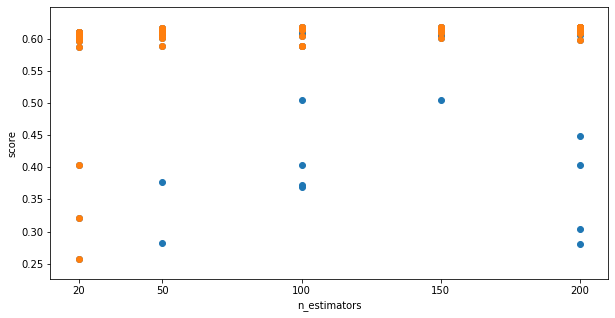

In [29]:
plt.figure(figsize=(10,5))
plt.scatter(cv_results_df['n_estimators'],cv_results_df['mean_test_score'])
plt.scatter(cv_results_df_subset['n_estimators'],cv_results_df_subset['mean_test_score'])
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.xticks(ticks=n_estimators, labels=n_estimators)
plt.show()

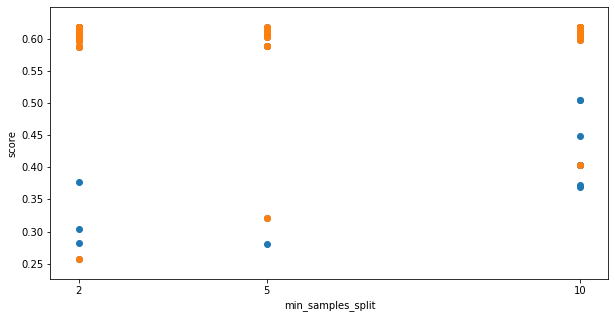

In [30]:
plt.figure(figsize=(10,5))
plt.scatter(cv_results_df['min_samples_split'],cv_results_df['mean_test_score'])
plt.scatter(cv_results_df_subset['min_samples_split'],cv_results_df_subset['mean_test_score'])
plt.xlabel('min_samples_split')
plt.ylabel('score')
plt.xticks(ticks=min_samples_split, labels=min_samples_split)
plt.show()

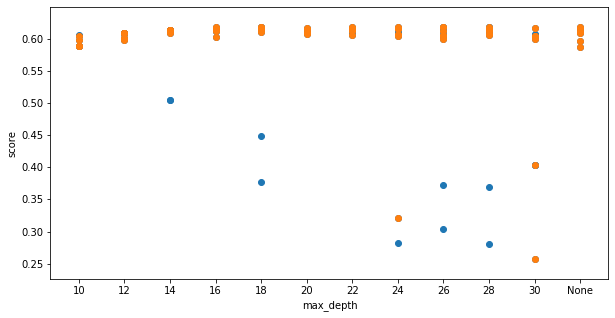

In [31]:
def convert_none_to_32(x):
    if x == None:
        x = 32
    return x

labels = [int(x) for x in np.linspace(10, 30, num = 11)]
labels.append('None')

plt.figure(figsize=(10,5))
plt.scatter(cv_results_df['max_depth'].apply(convert_none_to_32),cv_results_df['mean_test_score'])
plt.scatter(cv_results_df_subset['max_depth'].apply(convert_none_to_32),\
            cv_results_df_subset['mean_test_score'])
plt.xlabel('max_depth')
plt.ylabel('score')
plt.xticks(ticks=np.arange(10,33,2), labels=labels)
plt.show()

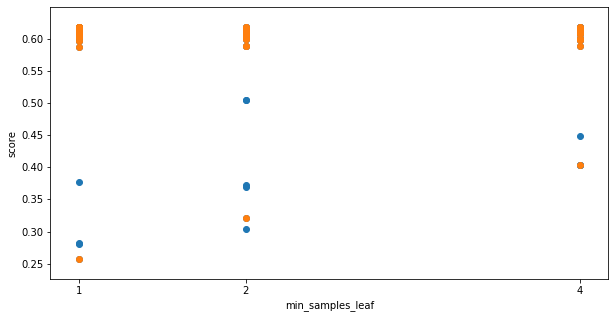

In [32]:
plt.figure(figsize=(10,5))
plt.scatter(cv_results_df['min_samples_leaf'],cv_results_df['mean_test_score'])
plt.scatter(cv_results_df_subset['min_samples_leaf'],cv_results_df_subset['mean_test_score'])
plt.xlabel('min_samples_leaf')
plt.ylabel('score')
plt.xticks(ticks=min_samples_leaf, labels=min_samples_leaf)
plt.show()

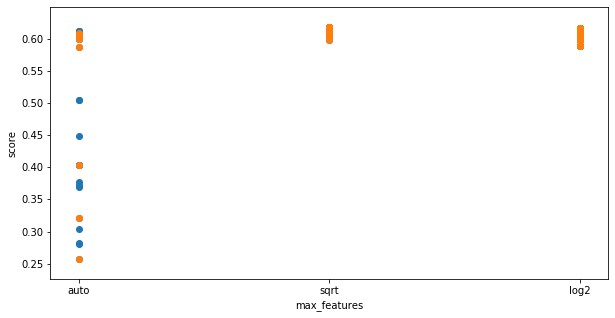

In [33]:
max_features = ['auto', 'sqrt', 'log2']

def convert_labels_to_num(x):
    if x == 'auto':
        x = 1
    elif x == 'sqrt':
        x = 2
    else:
        x = 3
    return x
            

plt.figure(figsize=(10,5))
plt.scatter(cv_results_df['max_features'].apply(convert_labels_to_num),cv_results_df['mean_test_score'])
plt.scatter(cv_results_df_subset['max_features'].apply(convert_labels_to_num),\
            cv_results_df_subset['mean_test_score'])
plt.xlabel('max_features')
plt.ylabel('score')
plt.xticks(ticks=[1,2,3], labels=max_features)
plt.show()

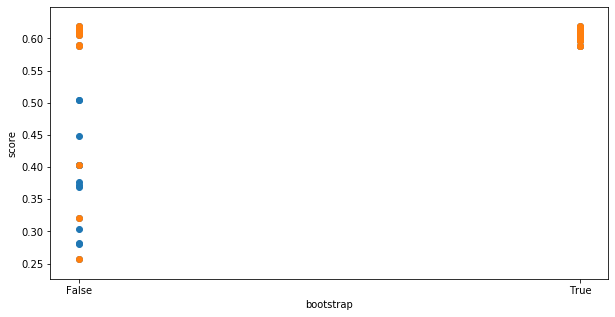

In [39]:
plt.figure(figsize=(10,5))
plt.scatter(cv_results_df['bootstrap'], cv_results_df['mean_test_score'])
plt.scatter(cv_results_df_subset['bootstrap'], cv_results_df_subset['mean_test_score'])
plt.xlabel('bootstrap')
plt.ylabel('score')
plt.xticks(bootstrap, labels=bootstrap)
plt.show()

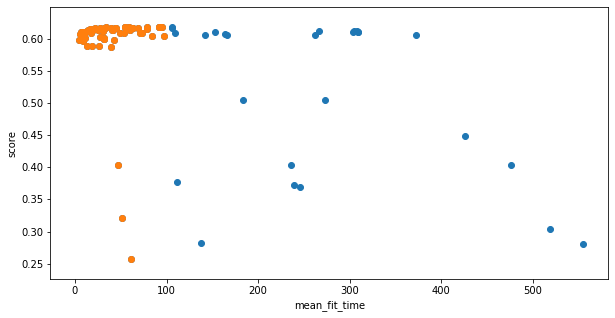

In [40]:
plt.figure(figsize=(10,5))
plt.scatter(cv_results_df['mean_fit_time'],cv_results_df['mean_test_score'])
plt.scatter(cv_results_df_subset['mean_fit_time'],cv_results_df_subset['mean_test_score'])
plt.xlabel('mean_fit_time')
plt.ylabel('score')
plt.show()

In [41]:
pprint(best_params)

{'bootstrap': False,
 'max_depth': 18,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 200}


In [42]:
index = int(np.argwhere(cv_results['rank_test_score']==1))
pprint(cv_results['mean_fit_time'][index])

95.27535557746887


In [43]:
pprint(best_score)

0.6185701581109284
